In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import json
import librosa
import numpy as np

pose_root = "/content/drive/MyDrive/Trial_db/pro_json"
audio_root = "/content/drive/MyDrive/Trial_db/pro_audio"
data = []
labels = []

label_mapping = {
    'salsa': 0,
    'tap': 1,
    'ballet': 2,
    'contemporary': 3,
    'hip_hop': 4
}

for label_folder in os.listdir(pose_root):
    label_folder_path = os.path.join(pose_root, label_folder)
    for filename in os.listdir(label_folder_path):
        if filename.endswith('.json'):
            # Load the pose data from the JSON file
            with open(os.path.join(label_folder_path, filename), "r") as f:
                pose_data = json.load(f)
            pose_data = np.array(pose_data)

            # Extract features from pose data
            distances = np.sqrt(np.sum((pose_data[:, 0, :] - pose_data[:, 1, :])**2, axis=-1))
            v1 = pose_data[:, 1, :] - pose_data[:, 0, :]
            v2 = pose_data[:, 1, :] - pose_data[:, 2, :]
            angles = np.arccos(np.sum(v1*v2, axis=-1) / (np.linalg.norm(v1, axis=-1) * np.linalg.norm(v2, axis=-1)))
            pose_features = np.stack([distances, angles], axis=-1)
            pose_features_mean = np.mean(pose_features, axis=0)

            # Load the corresponding audio file
            audio_filename = filename.replace('_data.json', '_processed.wav')

            audio, sr = librosa.load(os.path.join(audio_root, label_folder, audio_filename))

            # Compute the spectrogram of the audio signal and convert it to logarithmic scale
            spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
            log_spectrogram = librosa.power_to_db(spectrogram)
            log_spectrogram_mean = np.mean(log_spectrogram, axis=1)

            # Concatenate pose and audio features
            features = np.concatenate([pose_features_mean, log_spectrogram_mean])

            data.append(features)

            # The label is determined by the folder name
            label = label_mapping[label_folder.lower()]
            labels.append(label)

# Convert data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)


In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/drive/MyDrive/dance_model1_83.h5')
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_60 (Conv1D)          (None, 128, 256)          1024      
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 128, 256)          0         
                                                                 
 conv1d_61 (Conv1D)          (None, 126, 256)          196864    
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 126, 256)          0         
                                                                 
 max_pooling1d_30 (MaxPoolin  (None, 63, 256)          0         
 g1D)                                                            
                                                                 
 dropout_75 (Dropout)        (None, 63, 256)           0         
                                                     

In [ ]:
pretrained_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('dense_30').output)

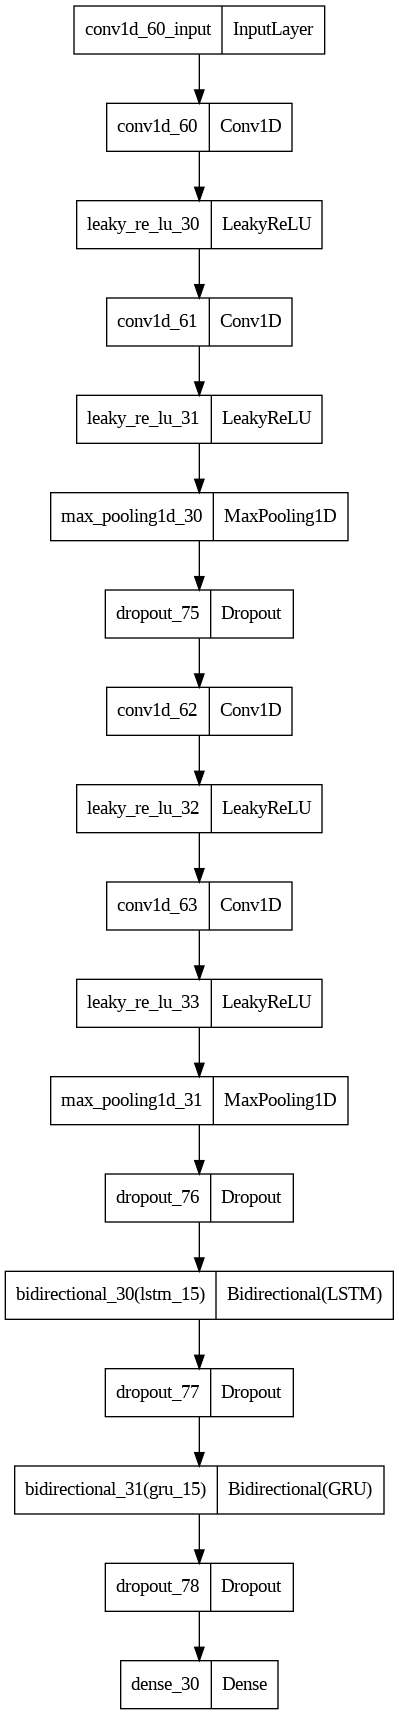

In [ ]:
tf.keras.utils.plot_model(pretrained_model)

In [ ]:
data = data.reshape((data.shape[0], data.shape[1], 1))
labels = labels.reshape((labels.shape[0], 1))

In [ ]:
features = np.array(pretrained_model(data))

In [ ]:
features.shape

(53, 256)

In [ ]:
def similarity(arr1, arr2):
    dot_product = np.dot(arr1, arr2)
    norm_arr1 = np.linalg.norm(arr1)
    norm_arr2 = np.linalg.norm(arr2)

    cosine_similarity = dot_product / (norm_arr1 * norm_arr2)

    return cosine_similarity

In [ ]:
n_samples = features.shape[0]
similarities = np.zeros((n_samples, n_samples))  # Initialize an array to store similarities

for i in range(n_samples):
    for j in range(n_samples):
      similarities[i, j] = similarity(features[i], features[j])
      if (i==j):
        similarities[i,j] = 0

print(similarities)

[[ 0.          0.91415787  0.5385651  ... -0.32377607  0.17180496
   0.13441847]
 [ 0.91415787  0.          0.62608373 ... -0.23416324  0.30469856
   0.22024547]
 [ 0.5385651   0.62608373  0.         ...  0.36900976  0.70524931
   0.78869534]
 ...
 [-0.32377607 -0.23416324  0.36900976 ...  0.          0.80608338
   0.77188045]
 [ 0.17180496  0.30469856  0.70524931 ...  0.80608338  0.
   0.87224883]
 [ 0.13441847  0.22024547  0.78869534 ...  0.77188045  0.87224883
   0.        ]]


In [ ]:
songs = [os.listdir(os.path.join(pose_root, i)) for i in os.listdir(pose_root)][1:]

In [ ]:
song_names = []
for i in songs:
  for j in i:
    song_names.append(j)

In [ ]:
print('THESE ARE THE SONG RECOMMENDATIONS (recommend the song on the left to the song on the right): \n\n')
for count, i in enumerate(similarities):
  print(f"{song_names[np.argmax(np.array(i))]}               {song_names[count]}")

THESE ARE THE SONG RECOMMENDATIONS (recommend the song on the left to the song on the right): 


Ballet7_data.json               Ballet_data.json
Ballet3_data.json               Ballet1_data.json
Contemporary5_data.json               Ballet2_data.json
Ballet6_data.json               Ballet3_data.json
Ballet9_data.json               Ballet4_data.json
Ballet2_data.json               Ballet5_data.json
Ballet3_data.json               Ballet6_data.json
Ballet_data.json               Ballet7_data.json
Ballet10_data.json               Ballet8_data.json
Ballet4_data.json               Ballet9_data.json
Ballet7_data.json               Ballet10_data.json
Ballet3_data.json               Ballet11_data.json
Contemporary8_data.json               Contemporary1_data.json
Contemporary7_data.json               Contemporary2_data.json
Contemporary9_data.json               Contemporary3_data.json
Contemporary6_data.json               Contemporary4_data.json
Contemporary_data.json               Contemporar